In [ ]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
print("Dataset loaded:", df.shape)
df.head()



Saving customer_churn_data.csv to customer_churn_data (2).csv
Dataset loaded: (5880, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
1,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,...,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
2,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,...,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
3,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
4,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,...,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes


In [4]:
import numpy as np

# detect target column
targets = [c for c in df.columns if c.lower() in ('churn','exited','is_churn','target')]
target = 'Churn' if 'Churn' in df.columns else (targets[0] if targets else None)
if target is None:
    raise SystemExit("No target column found. Rename churn column to 'Churn' or similar.")

# map yes/no to 1/0 if needed
if df[target].dtype == object:
    df[target] = df[target].astype(str).str.lower().map({'yes':1,'no':0,'true':1,'false':0})

# drop id-like columns
for c in ['customerID','CustomerID','ID','Id']:
    if c in df.columns: df.drop(c, axis=1, inplace=True)

# fix TotalCharges if present
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].astype(str).str.replace(' ',''),
                                       errors='coerce').fillna(df['TotalCharges'].median())

print("Using target:", target)
print("Columns after cleaning:", df.columns.tolist())
df.head()


NameError: name 'df' is not defined

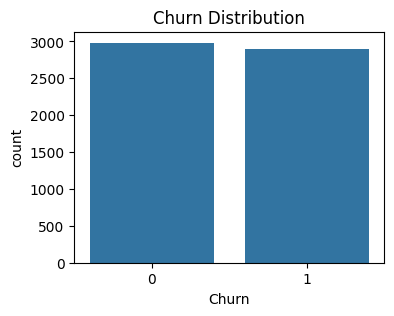

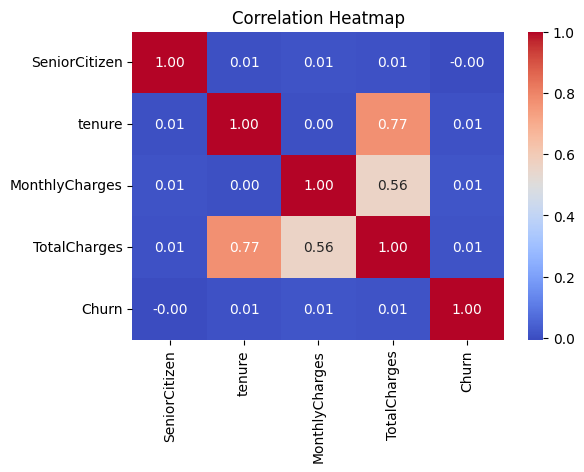

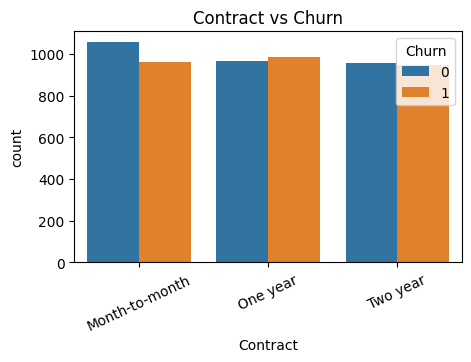

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.countplot(x=df[target])
plt.title("Churn Distribution")
plt.show()

num = df.select_dtypes('number')
if num.shape[1] > 1:
    plt.figure(figsize=(6,4))
    sns.heatmap(num.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Heatmap")
    plt.show()

if 'Contract' in df.columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x='Contract', hue=target, data=df)
    plt.title("Contract vs Churn")
    plt.xticks(rotation=25)
    plt.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# one-hot encode
X_all = pd.get_dummies(df.drop(columns=[target]), drop_first=True)
y = df[target].astype(int)

# remove constant columns if any
X_all = X_all.loc[:, X_all.nunique() > 1]

# quick importance using RandomForest to pick top 3 original features (aggregated)
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
rf.fit(X_all.fillna(0), y)
imp = pd.Series(rf.feature_importances_, index=X_all.columns)
# aggregate importance by base feature name (prefix before first '_')
agg = imp.groupby(lambda c: c.split('_')[0]).sum().sort_values(ascending=False)
top3 = list(agg.head(3).index)
print("Top 3 selected features (aggregated):", top3)

# choose all one-hot cols belonging to those top3 (or numeric column if present)
cols = [c for c in X_all.columns if c.split('_')[0] in top3]
X = X_all[cols].fillna(0)

# scale for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,
                                                    random_state=0, stratify=y)

# train KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("KNN trained on columns:", cols)



Top 3 selected features (aggregated): ['MonthlyCharges', 'TotalCharges', 'tenure']
KNN trained on columns: ['tenure', 'MonthlyCharges', 'TotalCharges']


Accuracy: 0.5102040816326531
ROC-AUC: 0.5038923281647767

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.54      0.53       596
           1       0.50      0.48      0.49       580

    accuracy                           0.51      1176
   macro avg       0.51      0.51      0.51      1176
weighted avg       0.51      0.51      0.51      1176



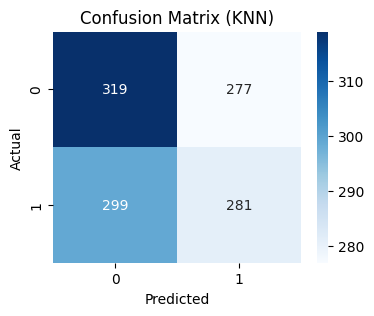

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = knn.predict(X_test)
# predict_proba available for KNN (when >=2 neighbors)
y_proba = knn.predict_proba(X_test)[:,1] if hasattr(knn, "predict_proba") else None

print("Accuracy:", accuracy_score(y_test, y_pred))
if y_proba is not None:
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (KNN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
